필요한 모듈 불러오기

In [413]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

sqlite DB에서 데이터 불러오기

In [414]:
con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\data\samsung.db")
df = pd.read_sql("SELECT * FROM '005930'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220531,67500,67500,66700,67400,24365002
20220530,67500,67800,66900,67700,14255484
20220527,66700,66900,66200,66500,11405555
20220526,66300,67200,65500,65900,15970890
20220525,66700,67100,65900,66400,15150490
...,...,...,...,...,...
19850109,126,126,122,123,324837
19850108,129,129,127,127,845098
19850107,129,130,128,129,771895


In [405]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2022-05-31', '2022-05-30', '2022-05-27', '2022-05-26',
               '2022-05-25', '2022-05-24', '2022-05-23', '2022-05-20',
               '2022-05-19', '2022-05-18',
               ...
               '1985-01-15', '1985-01-14', '1985-01-12', '1985-01-11',
               '1985-01-10', '1985-01-09', '1985-01-08', '1985-01-07',
               '1985-01-05', '1985-01-04'],
              dtype='datetime64[ns]', name='date', length=9881, freq=None)

데이터 정렬

In [406]:
df.sort_index(ascending=True, inplace=True)
df

df_list = df[:]
df

,open,high,low,close,volume
date,,,,,
1985-01-04,130,130,129,129,111765
1985-01-05,129,129,128,128,108497
1985-01-07,129,130,128,129,771895
1985-01-08,129,129,127,127,845098
1985-01-09,126,126,122,123,324837
...,...,...,...,...,...
2022-05-25,66700,67100,65900,66400,15150490
2022-05-26,66300,67200,65500,65900,15970890
2022-05-27,66700,66900,66200,66500,11405555


데이터 시각화

Text(0, 0.5, 'price')

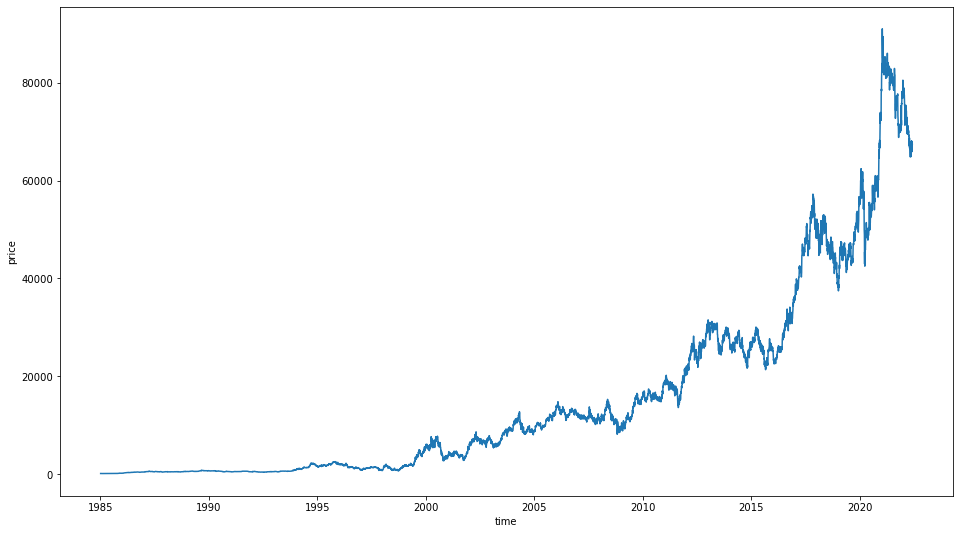

In [375]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

데이터 스케일링

In [376]:
from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()
df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))

# 스케일링 결과 확인
df


,open,high,low,close,volume
date,,,,,
1985-01-04,0.000155,0.000145,0.000157,0.000143,0.000342
1985-01-05,0.000144,0.000134,0.000145,0.000132,0.000332
1985-01-07,0.000144,0.000145,0.000145,0.000143,0.002363
1985-01-08,0.000144,0.000134,0.000134,0.000121,0.002587
1985-01-09,0.000111,0.000103,0.000078,0.000077,0.000995
...,...,...,...,...,...
2022-05-25,0.738313,0.692814,0.735974,0.729325,0.046385
2022-05-26,0.733877,0.693848,0.731499,0.723824,0.048897
2022-05-27,0.738313,0.690745,0.739330,0.730426,0.034920


train, test 분할 (20%가 test 데이터)

In [377]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)
print('train set 확인: ' ,  x_train.shape, y_train.shape)
print('test set 확인: ' ,  x_test.shape, y_test.shape)

train set 확인:  (7904, 4) (7904,)
test set 확인:  (1977, 4) (1977,)


C:\Users\gram\AppData\Local\Temp/ipykernel_6428/416191750.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


In [378]:
y_test

date
2014-05-19    0.317372
2014-05-20    0.318032
2014-05-21    0.315831
2014-05-22    0.312530
2014-05-23    0.312970
                ...   
2022-05-25    0.729325
2022-05-26    0.723824
2022-05-27    0.730426
2022-05-30    0.743629
2022-05-31    0.740328
Name: close, Length: 1977, dtype: float64

TensroFlow Dataset을 이용한 시퀀스 데이터 구성

In [379]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

하이퍼 파라미터 정의

In [380]:
WINDOW_SIZE=20
BATCH_SIZE=32

trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋

In [381]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

데이터셋의 구성을 확인

In [382]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


모델링

In [383]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])


 Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용

In [384]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.

In [385]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

val_loss 기준 체크포인터도 생성

In [386]:
import os
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    247/Unknown - 5s 12ms/step - loss: 1.2419e-05 - mse: 2.4838e-05
Epoch 1: val_loss improved from inf to 0.00903, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 6s 17ms/step - loss: 1.2419e-05 - mse: 2.4838e-05 - val_loss: 0.0090 - val_mse: 0.0181
Epoch 2/50
245/247 [============================>.] - ETA: 0s - loss: 9.1576e-06 - mse: 1.8315e-05
Epoch 2: val_loss improved from 0.00903 to 0.00867, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 7s 29ms/step - loss: 9.2387e-06 - mse: 1.8477e-05 - val_loss: 0.0087 - val_mse: 0.0173
Epoch 3/50
243/247 [============================>.] - ETA: 0s - loss: 7.8854e-06 - mse: 1.5771e-05
Epoch 3: val_loss improved from 0.00867 to 0.00840, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 6s 26ms/step - loss: 8.2105e-06 - mse: 1.6421e-05 - val_loss: 0.0084 - val_mse: 0.0168
Epoch 4/50
243/247 [============================>.] - ETA: 0s - los

저장한 ModelCheckpoint 를 로드

In [387]:
model.load_weights(filename)

test_data를 활용하여 예측

In [388]:
pred = model.predict(test_data)
pred.shape

(1957, 1)

In [389]:
pred

array([[0.3016309 ],
       [0.30029827],
       [0.29542255],
       ...,
       [0.60779923],
       [0.6081895 ],
       [0.6105638 ]], dtype=float32)

예측 데이터(스케일링) 시각화

In [390]:
print(pred.shape)
print(y_test.shape) # test data set의 앞의 20개 데이터로 21번째 데이터를 예측하기 때문

(1957, 1)
(1977,)


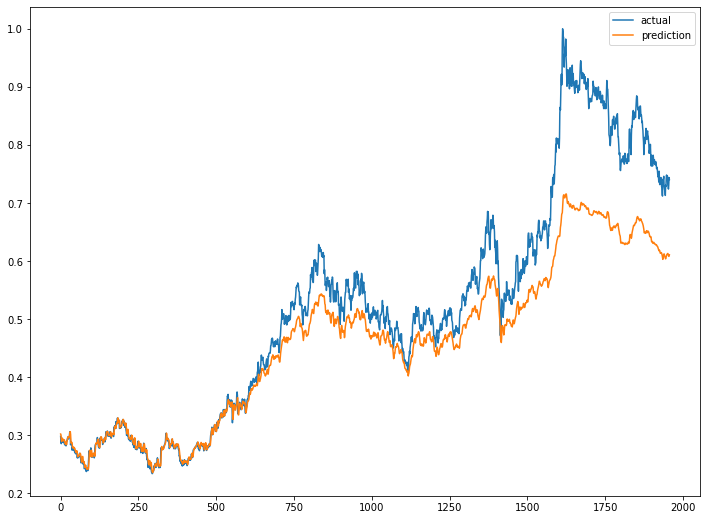

In [391]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

스케일링 전 값으로 역변환

In [392]:
rescaled_y_test = scaler1.inverse_transform(np.array(y_test).reshape(-1, 1))

rescaled_y_test 

array([[28960.],
       [29020.],
       [28820.],
       ...,
       [66500.],
       [67700.],
       [67400.]])

In [393]:
rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
rescaled_pred

array([[27529.424],
       [27408.307],
       [26965.184],
       ...,
       [55355.227],
       [55390.7  ],
       [55606.484]], dtype=float32)

MSE 계산

In [394]:
MSE = np.square(np.subtract((rescaled_y_test)[20:], rescaled_pred)).mean()
MSE

64783335.07282008

RMSE 계산

In [395]:
import math
rmse = math.sqrt(MSE)
rmse

8048.80954382821

시각화

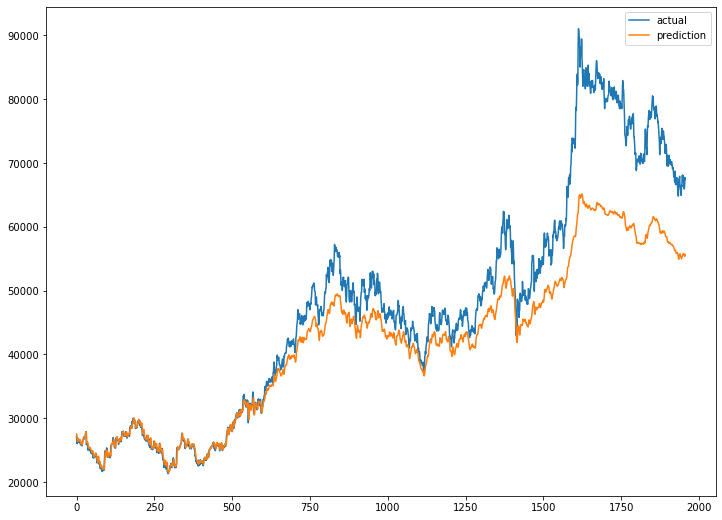

In [396]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(rescaled_y_test)[20:], label='actual')
plt.plot(rescaled_pred, label='prediction')
plt.legend()
plt.show()

* 데이터 개수에 따른 성능 평가

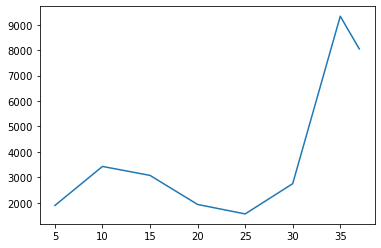

In [397]:
import matplotlib.pyplot as plt

year = [5, 10, 15, 20, 25, 30, 35, 37]
MSE_list = [1892, 3427, 3074, 1932, 1560, 2749, 9333, 8048] # 뒤에서부터 5년씩 끊음, 1월 1일 기준으로 => 처음 RMSE가 2017 ~ 2022

plt.plot(year, MSE_list) # line 그래프를 그립니다
plt.show() # 그래프를 화면에 보여줍니다

In [1]:
def data_sample_metrics(n):
    
    import pandas as pd
    import sqlite3
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime
    import seaborn as sns
    
    
    con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\data\samsung.db")
    df = pd.read_sql("SELECT * FROM '005930'", con, index_col=None)
    df.rename(columns={'index':'date'}, inplace=True)
    df = df.set_index('date')
    
    num_iter = (int(df.index[0][:4]) - int(df.index[len(df) - 1][:4]) ) // 5
    end_year = int(df.index[0][:4])
    
    RMSE_list = []
    year_list = [n for n in range(1, num_iter + 1 + 1)]
    
    df.index = pd.DatetimeIndex(df.index)
    
    df.sort_index(ascending=True, inplace=True)
    
    for i in range(1, num_iter + 1 + 1): # 첫 번째 1 더한거는 1부터 시작하기 때문, 두번째 1 더한거는 마지막 범위 빠지기 때문
        con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\data\samsung.db")
        df = pd.read_sql("SELECT * FROM '005930'", con, index_col=None)
        df.rename(columns={'index':'date'}, inplace=True)
        df = df.set_index('date')
        df.index = pd.DatetimeIndex(df.index)
        df.sort_index(ascending=True, inplace=True)
        if i == num_iter + 1:
            df = df[:]
        else:
            year = end_year - i * n
            year = str(year) + '-01-01'
            df = df[year:]
            
        from sklearn.preprocessing import MinMaxScaler
        # 피처값 스케일링
        scaler = MinMaxScaler()
        df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])
        # 타켓 스케일링
        scaler1 = MinMaxScaler()
        df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))
        
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)
        
        import tensorflow as tf
        def windowed_dataset(series, window_size, batch_size, shuffle):
            series = tf.expand_dims(series, axis=-1)
            ds = tf.data.Dataset.from_tensor_slices(series)
            ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
            ds = ds.flat_map(lambda w: w.batch(window_size + 1))
            if shuffle:
                ds = ds.shuffle(1000)
            ds = ds.map(lambda w: (w[:-1], w[-1]))
            return ds.batch(batch_size).prefetch(1)
        
        WINDOW_SIZE=20
        BATCH_SIZE=32
        
        train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
        test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)
        
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
        from tensorflow.keras.losses import Huber
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


        model = Sequential([
            # 1차원 feature map 생성
            Conv1D(filters=32, kernel_size=5,
                   padding="causal",
                   activation="relu",
                   input_shape=[WINDOW_SIZE, 1]),
            # LSTM
            LSTM(16, activation='tanh'),
            Dense(16, activation="relu"),
            Dense(1),
            ])
        
        loss = Huber()
        optimizer = Adam(0.0005)
        model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
        
        earlystopping = EarlyStopping(monitor='val_loss', patience=10)
        
        import os
        filename = os.path.join('tmp', 'ckeckpointer.ckpt')
        checkpoint = ModelCheckpoint(filename, 
                                     save_weights_only=True, 
                                     save_best_only=True, 
                                     monitor='val_loss', 
                                     verbose=1)

        history = model.fit(train_data, 
                            validation_data=(test_data), 
                            epochs=50, 
                            callbacks=[checkpoint, earlystopping])
        
        model.load_weights(filename)
        
        pred = model.predict(test_data)
        
        rescaled_y_test = scaler1.inverse_transform(np.array(y_test).reshape(-1, 1))
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

        rescaled_y_test 
        
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
        rescaled_pred
        
        MSE = np.square(np.subtract((rescaled_y_test)[20:], rescaled_pred)).mean()
        import math
        RMSE = math.sqrt(MSE)
        RMSE_list.append(RMSE)
    
    plt.plot(year_list, RMSE_list) # line 그래프를 그립니다
    plt.show() # 그래프를 화면에 보여줍니다

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     31/Unknown - 3s 11ms/step - loss: 0.0447 - mse: 0.0894
Epoch 1: val_loss improved from inf to 0.08183, saving model to tmp\ckeckpointer.ckpt
33/33 [==============================] - 7s 139ms/step - loss: 0.0434 - mse: 0.0869 - val_loss: 0.0818 - val_mse: 0.1637
Epoch 2/50
30/33 [==========================>...] - ETA: 0s - loss: 0.0076 - mse: 0.0152
Epoch 2: val_loss improved from 0.08183 to 0.00488, saving model to tmp\ckeckpointer.ckpt
33/33 [==============================] - 1s 20ms/step - loss: 0.0073 - mse: 0.0145 - val_loss: 0.0049 - val_mse: 0.0098
Epoch 3/50
31/33 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0033
Epoch 3: val_loss improved from 0.00488 to 0.00064, saving model to tmp\ckeckpointer.ckpt
33/33 [==============================] - 1s 22ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 6.4340e-04 - val_mse: 0.0013
Epoch 4/50
31/33 [===========================>..] - ETA: 0s - loss: 6.6889e-04 - mse: 0.0013
Epoch 4: val_loss did not i

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     61/Unknown - 5s 12ms/step - loss: 0.0020 - mse: 0.0041
Epoch 1: val_loss improved from inf to 0.00203, saving model to tmp\ckeckpointer.ckpt
64/64 [==============================] - 6s 30ms/step - loss: 0.0020 - mse: 0.0039 - val_loss: 0.0020 - val_mse: 0.0041
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 1.5670e-04 - mse: 3.1339e-04
Epoch 2: val_loss did not improve from 0.00203
64/64 [==============================] - 1s 17ms/step - loss: 1.5670e-04 - mse: 3.1339e-04 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 3/50
61/64 [===========================>..] - ETA: 0s - loss: 1.4923e-04 - mse: 2.9846e-04
Epoch 3: val_loss did not improve from 0.00203
64/64 [==============================] - 1s 13ms/step - loss: 1.5530e-04 - mse: 3.1061e-04 - val_loss: 0.0027 - val_mse: 0.0054
Epoch 4/50
60/64 [===========================>..] - ETA: 0s - loss: 1.4267e-04 - mse: 2.8534e-04
Epoch 4: val_loss did not improve from 0.00203
64/64 [============================

61/64 [===========================>..] - ETA: 0s - loss: 7.3974e-05 - mse: 1.4795e-04
Epoch 30: val_loss did not improve from 0.00108
64/64 [==============================] - 1s 14ms/step - loss: 7.4925e-05 - mse: 1.4985e-04 - val_loss: 0.0011 - val_mse: 0.0023
Epoch 31/50
64/64 [==============================] - ETA: 0s - loss: 7.7410e-05 - mse: 1.5482e-04
Epoch 31: val_loss did not improve from 0.00108
64/64 [==============================] - 2s 20ms/step - loss: 7.7410e-05 - mse: 1.5482e-04 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 32/50
61/64 [===========================>..] - ETA: 0s - loss: 7.8083e-05 - mse: 1.5617e-04
Epoch 32: val_loss did not improve from 0.00108
64/64 [==============================] - 1s 13ms/step - loss: 7.9334e-05 - mse: 1.5867e-04 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 33/50
61/64 [===========================>..] - ETA: 0s - loss: 6.7843e-05 - mse: 1.3569e-04
Epoch 33: val_loss did not improve from 0.00108
64/64 [==============================] - 1s 

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
     93/Unknown - 4s 11ms/step - loss: 4.1536e-04 - mse: 8.3072e-04
Epoch 1: val_loss improved from inf to 0.00043, saving model to tmp\ckeckpointer.ckpt
95/95 [==============================] - 5s 23ms/step - loss: 4.1059e-04 - mse: 8.2118e-04 - val_loss: 4.3335e-04 - val_mse: 8.6671e-04
Epoch 2/50
91/95 [===========================>..] - ETA: 0s - loss: 7.5397e-05 - mse: 1.5079e-04
Epoch 2: val_loss did not improve from 0.00043
95/95 [==============================] - 2s 16ms/step - loss: 7.6749e-05 - mse: 1.5350e-04 - val_loss: 6.9919e-04 - val_mse: 0.0014
Epoch 3/50
93/95 [============================>.] - ETA: 0s - loss: 7.1522e-05 - mse: 1.4304e-04
Epoch 3: val_loss did not improve from 0.00043
95/95 [==============================] - 2s 15ms/step - loss: 7.2265e-05 - mse: 1.4453e-04 - val_loss: 4.3639e-04 - val_mse: 8.7277e-04
Epoch 4/50
91/95 [===========================>..] - ETA: 0s - loss: 6.6351e-05 - mse: 1.3270e-04
Epoch 4: val_loss did not improve from 0.00043

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    124/Unknown - 4s 13ms/step - loss: 1.6321e-04 - mse: 3.2643e-04
Epoch 1: val_loss improved from inf to 0.00205, saving model to tmp\ckeckpointer.ckpt
126/126 [==============================] - 5s 21ms/step - loss: 1.6257e-04 - mse: 3.2515e-04 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 2/50
123/126 [============================>.] - ETA: 0s - loss: 5.4713e-05 - mse: 1.0943e-04
Epoch 2: val_loss improved from 0.00205 to 0.00142, saving model to tmp\ckeckpointer.ckpt
126/126 [==============================] - 2s 14ms/step - loss: 5.5567e-05 - mse: 1.1113e-04 - val_loss: 0.0014 - val_mse: 0.0028
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 4.2587e-05 - mse: 8.5175e-05
Epoch 3: val_loss improved from 0.00142 to 0.00092, saving model to tmp\ckeckpointer.ckpt
126/126 [==============================] - 2s 15ms/step - loss: 4.2721e-05 - mse: 8.5441e-05 - val_loss: 9.1751e-04 - val_mse: 0.0018
Epoch 4/50
123/126 [============================>.] - ETA: 0s -

124/126 [============================>.] - ETA: 0s - loss: 2.5188e-05 - mse: 5.0375e-05
Epoch 28: val_loss did not improve from 0.00025
126/126 [==============================] - 2s 14ms/step - loss: 2.5527e-05 - mse: 5.1053e-05 - val_loss: 3.7854e-04 - val_mse: 7.5709e-04
Epoch 29/50
125/126 [============================>.] - ETA: 0s - loss: 2.4191e-05 - mse: 4.8382e-05
Epoch 29: val_loss improved from 0.00025 to 0.00019, saving model to tmp\ckeckpointer.ckpt
126/126 [==============================] - 2s 14ms/step - loss: 2.4294e-05 - mse: 4.8588e-05 - val_loss: 1.9397e-04 - val_mse: 3.8793e-04
Epoch 30/50
126/126 [==============================] - ETA: 0s - loss: 2.3489e-05 - mse: 4.6977e-05
Epoch 30: val_loss did not improve from 0.00019
126/126 [==============================] - 2s 13ms/step - loss: 2.3489e-05 - mse: 4.6977e-05 - val_loss: 2.2254e-04 - val_mse: 4.4508e-04
Epoch 31/50
125/126 [============================>.] - ETA: 0s - loss: 2.2742e-05 - mse: 4.5483e-05
Epoch 31: v

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    155/Unknown - 4s 10ms/step - loss: 5.8732e-05 - mse: 1.1746e-04
Epoch 1: val_loss improved from inf to 0.00328, saving model to tmp\ckeckpointer.ckpt
159/159 [==============================] - 5s 15ms/step - loss: 5.8356e-05 - mse: 1.1671e-04 - val_loss: 0.0033 - val_mse: 0.0066
Epoch 2/50
155/159 [============================>.] - ETA: 0s - loss: 2.2904e-05 - mse: 4.5808e-05
Epoch 2: val_loss improved from 0.00328 to 0.00228, saving model to tmp\ckeckpointer.ckpt
159/159 [==============================] - 2s 12ms/step - loss: 2.3326e-05 - mse: 4.6652e-05 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 3/50
157/159 [============================>.] - ETA: 0s - loss: 2.3111e-05 - mse: 4.6222e-05
Epoch 3: val_loss did not improve from 0.00228
159/159 [==============================] - 2s 12ms/step - loss: 2.3210e-05 - mse: 4.6420e-05 - val_loss: 0.0028 - val_mse: 0.0056
Epoch 4/50
156/159 [============================>.] - ETA: 0s - loss: 2.4091e-05 - mse: 4.8182e-05
Epoch 4: va

Epoch 30/50
155/159 [============================>.] - ETA: 0s - loss: 1.1424e-05 - mse: 2.2848e-05
Epoch 30: val_loss did not improve from 0.00107
159/159 [==============================] - 2s 12ms/step - loss: 1.1693e-05 - mse: 2.3386e-05 - val_loss: 0.0015 - val_mse: 0.0030
Epoch 31/50
156/159 [============================>.] - ETA: 0s - loss: 1.1673e-05 - mse: 2.3345e-05
Epoch 31: val_loss did not improve from 0.00107
159/159 [==============================] - 2s 12ms/step - loss: 1.1816e-05 - mse: 2.3632e-05 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 32/50
158/159 [============================>.] - ETA: 0s - loss: 1.0791e-05 - mse: 2.1582e-05
Epoch 32: val_loss did not improve from 0.00107
159/159 [==============================] - 2s 14ms/step - loss: 1.0840e-05 - mse: 2.1681e-05 - val_loss: 0.0016 - val_mse: 0.0032


C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    196/Unknown - 5s 12ms/step - loss: 1.7572e-05 - mse: 3.5143e-05
Epoch 1: val_loss improved from inf to 0.00418, saving model to tmp\ckeckpointer.ckpt
196/196 [==============================] - 6s 16ms/step - loss: 1.7572e-05 - mse: 3.5143e-05 - val_loss: 0.0042 - val_mse: 0.0084
Epoch 2/50
193/196 [============================>.] - ETA: 0s - loss: 1.4100e-05 - mse: 2.8200e-05
Epoch 2: val_loss did not improve from 0.00418
196/196 [==============================] - 3s 13ms/step - loss: 1.4344e-05 - mse: 2.8687e-05 - val_loss: 0.0061 - val_mse: 0.0122
Epoch 3/50
192/196 [============================>.] - ETA: 0s - loss: 1.3075e-05 - mse: 2.6150e-05
Epoch 3: val_loss did not improve from 0.00418
196/196 [==============================] - 3s 13ms/step - loss: 1.3516e-05 - mse: 2.7032e-05 - val_loss: 0.0043 - val_mse: 0.0086
Epoch 4/50
191/196 [============================>.] - ETA: 0s - loss: 1.2961e-05 - mse: 2.5921e-05
Epoch 4: val_loss improved from 0.00418 to 0.00416, sa

Epoch 29/50
194/196 [============================>.] - ETA: 0s - loss: 6.0425e-06 - mse: 1.2085e-05
Epoch 29: val_loss did not improve from 0.00136
196/196 [==============================] - 3s 12ms/step - loss: 6.1143e-06 - mse: 1.2229e-05 - val_loss: 0.0016 - val_mse: 0.0033
Epoch 30/50
194/196 [============================>.] - ETA: 0s - loss: 5.6723e-06 - mse: 1.1345e-05
Epoch 30: val_loss improved from 0.00136 to 0.00123, saving model to tmp\ckeckpointer.ckpt
196/196 [==============================] - 3s 13ms/step - loss: 5.7001e-06 - mse: 1.1400e-05 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 31/50
194/196 [============================>.] - ETA: 0s - loss: 5.4895e-06 - mse: 1.0979e-05
Epoch 31: val_loss did not improve from 0.00123
196/196 [==============================] - 2s 12ms/step - loss: 5.5450e-06 - mse: 1.1090e-05 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 32/50
196/196 [==============================] - ETA: 0s - loss: 6.2405e-06 - mse: 1.2481e-05
Epoch 32: val_loss did 

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    227/Unknown - 5s 11ms/step - loss: 1.1094e-05 - mse: 2.2189e-05
Epoch 1: val_loss improved from inf to 0.00440, saving model to tmp\ckeckpointer.ckpt
232/232 [==============================] - 6s 15ms/step - loss: 1.1300e-05 - mse: 2.2601e-05 - val_loss: 0.0044 - val_mse: 0.0088
Epoch 2/50
229/232 [============================>.] - ETA: 0s - loss: 9.2053e-06 - mse: 1.8411e-05
Epoch 2: val_loss improved from 0.00440 to 0.00431, saving model to tmp\ckeckpointer.ckpt
232/232 [==============================] - 3s 13ms/step - loss: 9.3219e-06 - mse: 1.8644e-05 - val_loss: 0.0043 - val_mse: 0.0086
Epoch 3/50
232/232 [==============================] - ETA: 0s - loss: 8.7288e-06 - mse: 1.7458e-05
Epoch 3: val_loss did not improve from 0.00431
232/232 [==============================] - 3s 13ms/step - loss: 8.7288e-06 - mse: 1.7458e-05 - val_loss: 0.0046 - val_mse: 0.0092
Epoch 4/50
228/232 [============================>.] - ETA: 0s - loss: 7.9064e-06 - mse: 1.5813e-05
Epoch 4: va

C:\Users\gram\AppData\Local\Temp/ipykernel_22500/2750288456.py:49: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


Epoch 1/50
    243/Unknown - 6s 12ms/step - loss: 1.0695e-05 - mse: 2.1391e-05
Epoch 1: val_loss improved from inf to 0.00245, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 7s 17ms/step - loss: 1.1085e-05 - mse: 2.2169e-05 - val_loss: 0.0025 - val_mse: 0.0049
Epoch 2/50
243/247 [============================>.] - ETA: 0s - loss: 7.6651e-06 - mse: 1.5330e-05
Epoch 2: val_loss improved from 0.00245 to 0.00145, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 4s 14ms/step - loss: 7.9199e-06 - mse: 1.5840e-05 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 3/50
244/247 [============================>.] - ETA: 0s - loss: 8.0228e-06 - mse: 1.6046e-05
Epoch 3: val_loss improved from 0.00145 to 0.00100, saving model to tmp\ckeckpointer.ckpt
247/247 [==============================] - 4s 14ms/step - loss: 8.1258e-06 - mse: 1.6252e-05 - val_loss: 9.9777e-04 - val_mse: 0.0020
Epoch 4/50
244/247 [============================>.] - ETA: 0s -

Epoch 29/50
246/247 [============================>.] - ETA: 0s - loss: 4.6225e-06 - mse: 9.2449e-06
Epoch 29: val_loss did not improve from 0.00035
247/247 [==============================] - 4s 14ms/step - loss: 4.6662e-06 - mse: 9.3325e-06 - val_loss: 6.2579e-04 - val_mse: 0.0013
Epoch 30/50
245/247 [============================>.] - ETA: 0s - loss: 4.2125e-06 - mse: 8.4250e-06
Epoch 30: val_loss did not improve from 0.00035
247/247 [==============================] - 4s 15ms/step - loss: 4.2791e-06 - mse: 8.5581e-06 - val_loss: 4.0489e-04 - val_mse: 8.0977e-04


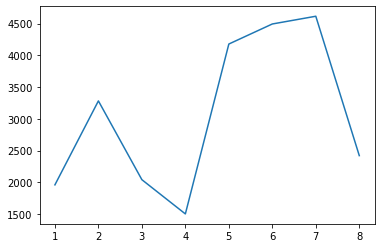

In [2]:
data_sample_metrics(5)